In [5]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.optim as optim
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from transformers import AdamW

In [6]:
# --------- MODEL CREATION ---------
class BertRegressor(nn.Module):
    '''Addition of a multi-output regression layer to BERT model.'''
    def __init__(self, drop_rate=0.2):
        ''' Definition of BERT model and regression model '''
        super().__init__()
        dim_in, dim_out = 768, 24
        self.model = BertModel.from_pretrained('bert-base-cased')
        # Freeze layers of BERT
        modules = [self.model.embeddings, *self.model.encoder.layer[:5]]
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False
        # for param in self.model.parameters():
        #     param.requires_grad = False
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(dim_in, 2000),
            nn.ReLU(),
            nn.Linear(2000, dim_out)
        )
        self.double()

    def forward(self, input_ids, attention_masks):
        ''' Connecting output of BERT to regression layer '''
        bert_out = self.model(input_ids, attention_masks)
        cls_outputs = bert_out[1]
        regression_out = self.regressor(cls_outputs)
        return regression_out

model = BertRegressor(drop_rate=0.2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# --------------- TOKENIZATION AND DATASET ----------------
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

sql_conn = sqlite3.Connection("../../data/title_dataset-PREVIEW.db")

# All data
data = pd.read_sql(
    "SELECT * FROM titles",
    sql_conn
)

standard_scaler = StandardScaler()

# Slice of first 100 entries
train_titles = data.iloc[:100, 0]
standard_scaler.fit(data.iloc[:100, 1:].to_numpy())
train_labels = standard_scaler.transform(data.iloc[:100, 1:].to_numpy())
# train_data.head(20)

tokenized_input = tokenizer(text=train_titles.tolist(),
                            add_special_tokens=True,
                            padding='longest',
                            return_attention_mask=True)
                        

# Creation of TensorDataset
train_inputs = torch.tensor(tokenized_input['input_ids'])
train_masks = torch.tensor(tokenized_input['attention_mask'])
train_labels = torch.tensor(train_labels)
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)


In [8]:
# -------------------- TRAINING --------------------

batch_size = 25
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)
model.to(device)

loss_fn = nn.MSELoss()
# this learning rate was used in original BERT paper
optimizer = optim.SGD(model.parameters(), lr=5e-5)

loss_log = []
epochs = 5
for epoch in range(epochs):
    print(f"epoch {epoch} --------")
    model.train()
    for step, batch in enumerate(train_dataloader):
        print(f"batch {step}")
        inputs, masks, labels = tuple(row.to(device) for row in batch)
        model.zero_grad()
        outputs = model.forward(inputs, masks)
        loss = loss_fn(outputs.squeeze(), labels.squeeze())
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()


cpu
epoch 0 --------
batch 0
batch 1
batch 2
batch 3
epoch 1 --------
batch 0
batch 1
batch 2
batch 3
epoch 2 --------
batch 0
batch 1
batch 2
batch 3
epoch 3 --------
batch 0
batch 1
batch 2
batch 3
epoch 4 --------
batch 0
batch 1
batch 2
batch 3


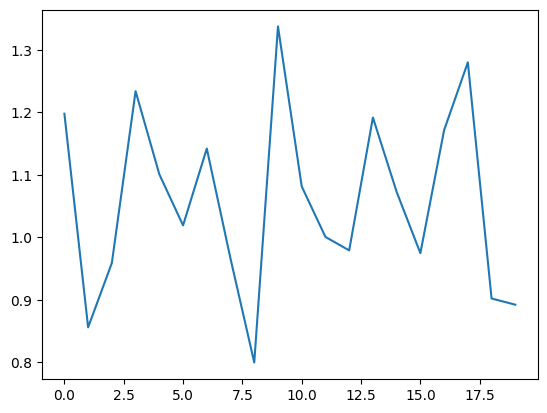

In [9]:
# ------------ PLOTS ---------------

plt.plot(range(len(loss_log)), loss_log)
plt.show()
